## Import packages

In [ ]:
# transfomers & pyLDAvis are not installed locally on Colab
# Install them permanently to a specific gDrive directory to avoid having to re-install upon every new runtime
# Do note that importing installed packages from gDrive will take longer

!pip install transformers -t '/content/drive/MyDrive/Colab Notebooks/Packages'
!pip install pyLDAvis -t '/content/drive/MyDrive/Colab Notebooks/Packages'

In [ ]:
# mount gDrive if you are on colab
from google.colab import drive
drive.mount('/content/drive')

# On Colab, some packages(e.g. transfomers) need to be permanently installed on gdrive 
# to avoid re-installing everytime a new runtime is requested
import sys
# add my gdrive location to sys.path
nb_path = '/content/drive/MyDrive/Colab Notebooks/Packages' 
sys.path.insert(0,nb_path)

# load data
import pandas as pd
path = "/content/drive/My Drive/BT4222 Group Project/Final Project/Codes/labeled_data.csv"
twitter_hate = pd.read_csv(path)

# basic tokenisation & stop words removal using spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# text cleaning 
import string
import re 

# EDA
import itertools
import collections
import pyLDAvis.sklearn
# from gensim.models import Phrases
# from gensim.models.word2vec import LineSentence
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

# tracking iterations
from tqdm import tqdm

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# model set-up & evaluation
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# importing training packages
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel # for BERT implementation
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# handle warnings
import warnings
warnings.filterwarnings('ignore', 'SelectableGroups dict interface')
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Data Preprocessing

 ##### Deciding which package to use:  
 - spaCy
 
 spaCy outperforms NLTK in **word tokenization** & **Part-of-speech tagging**, and though NLTK performs faster for **Sentence tokenization** through simple attempts at splitting text into sentences, spaCy constructs a syntactic tree for each sentence which is a more robust method that yields more information about the text.

 Here we assume that the Out of bag samples are all in English, and as such spaCy can be used


 ![https://www.thedataincubator.com/wp-content/uploads/timing.png](https://www.thedataincubator.com/wp-content/uploads/timing.png)

In [ ]:
import pandas as pd

### Mounting Drive and importing dataset
from google.colab import drive
drive.mount('/content/drive')

# glenn's path = "/content/drive/My Drive/Project Code/labeled_data.csv"
path = "/content/drive/My Drive/BT4222 Group Project/Project Code/labeled_data.csv"
#path = "/content/drive/My Drive/labeled_data.csv"
twitter_hate = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
### Extract and review dataset
twitter_hate.head(20)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


### Cleaning Tweets using spacy and scikit learn

https://www.kaggle.com/code/thebrownviking20/topic-modelling-with-spacy-and-scikit-learn/notebook

In [ ]:
stopwords = list(STOP_WORDS) +['rt'] # adding 'rt' to stopwords. 'rt' only refers to retweet does not give value to tweet
punctuations = list(string.punctuation) 
punctuations.remove('#') # remove '#' from punctuations as hashtags add meaning to tweet
parser = English()

def spacy_tokenizer(sentence):
    # input: tweet
    # output: lowercased tweet, with stopwords and punctuations removed
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

tqdm.pandas()
twitter_hate["tweets_cleaned_v1"] = twitter_hate["tweet"].progress_apply(spacy_tokenizer)

100%|██████████| 24783/24783 [00:08<00:00, 3049.03it/s]


In [ ]:
tqdm.pandas()

### removes the following from each tweet:
    ### @user_names
    ### URL links 
    ### Numbers
    ### underscores

twitter_hate["tweets_cleaned"] = twitter_hate["tweets_cleaned_v1"].progress_apply(lambda x: re.sub(r"(_[A-Za-z0-9-_]+)|(@[A-Za-z0-9]+)|[^\w\s]|http\S+|[0-9]", "",x))

twitter_hate.head(1000) ### visual check


100%|██████████| 24783/24783 [00:00<00:00, 159806.04it/s]


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,tweets_cleaned_v1,tweets_cleaned
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,@mayasolovely woman complain cleaning house am...,woman complain cleaning house amp man trash
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,@mleew17 boy dats cold ... tyga dwn bad cuffin...,boy dats cold tyga dwn bad cuffin dat hoe st...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,@urkindofbrand dawg @80sbaby4life fuck bitch s...,dawg fuck bitch start cry confused shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,@c_g_anderson @viva_based look like tranny,look like tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,@shenikaroberts shit hear true faker bitch tol...,shit hear true faker bitch told ya
...,...,...,...,...,...,...,...,...,...
995,1017,3,0,3,0,1,&#128514;&#128514;&#128514;&#128514; RT @SMASH...,# 128514;&#128514;&#128514;&#128514 @smashavel...,murda sucking bitches howdhow
996,1018,3,0,3,0,1,&#128514;&#128514;&#128514;&#128514; bitch if ...,# 128514;&#128514;&#128514;&#128514 bitch hobb...,bitch hobbit need let know right
997,1019,3,0,2,1,1,&#128514;&#128514;&#128514;&#128514; these fol...,# 128514;&#128514;&#128514;&#128514 folks bad ...,folks bad talk trash
998,1020,6,0,6,0,1,&#128514;&#128514;&#128514;&#128514;&#128514; ...,# 128514;&#128514;&#128514;&#128514;&#128514 b...,brittany bitch u dog man


In [ ]:
def bucket (x):
  # input: class column (0,1,2)
  # output: bucket hate + offensive = 1, neutral = 0
  if x == 2:
    return 0
  return 1

twitter_hate["class"] = twitter_hate['class'].progress_apply(bucket)

100%|██████████| 24783/24783 [00:00<00:00, 698107.01it/s]


In [ ]:
### Extract the tweet (tweets_cleaned) and bucketed class (class) into a new dataframe
twitter_cleaned = twitter_hate[["tweets_cleaned","class"]]

twitter_cleaned.head(100)

,tweets_cleaned,class
0,woman complain cleaning house amp man trash,0
1,boy dats cold tyga dwn bad cuffin dat hoe st...,1
2,dawg fuck bitch start cry confused shit,1
3,look like tranny,1
4,shit hear true faker bitch told ya,1
...,...,...
95,going school sucks dick hoes attend,1
96,way fuck yo bitch year old,1
97,come bring food car retard,1
98,richnow hella tinder hoes friend anymore chil...,1


In [ ]:
### Alternative way of representing class to allow running Neural Network
hate = []
neu = []
for i in twitter_cleaned["class"]:
  if i == 0:
    hate.append(0)
    neu.append(1)
  elif i == 1:
    hate.append(1)
    neu.append(0)
twitter_cleaned["hate"] = hate
twitter_cleaned["neutral"] = neu

twitter_cleaned = twitter_cleaned[["tweets_cleaned","neutral","hate"]]

twitter_cleaned.head()

,tweets_cleaned,neutral,hate
0,woman complain cleaning house amp man trash,1,0
1,boy dats cold tyga dwn bad cuffin dat hoe st...,0,1
2,dawg fuck bitch start cry confused shit,0,1
3,look like tranny,0,1
4,shit hear true faker bitch told ya,0,1


## 2. EDA

### Understanding the Data: removing repeated top words 

In [ ]:
### Trying to identify the top few word that is used in each class

# For class neutral, neutral = 1
nwl = [tweet.split() for tweet in twitter_cleaned.tweets_cleaned[twitter_cleaned['neutral'] == 1 ]]

word_list_neutral = list(itertools.chain(*nwl))

neutral_count_word = collections.Counter(word_list_neutral)

print(f'top 20 words in neutral class: {neutral_count_word.most_common(20)}')

# For class hate, hate = 1
hwl = [tweet.split() for tweet in twitter_cleaned.tweets_cleaned[twitter_cleaned['hate'] == 1 ]]

word_list_hate = list(itertools.chain(*hwl))

hate_count_word = collections.Counter(word_list_hate)

print(f'top 20 words in hate class: {hate_count_word.most_common(20)}')

top 20 words in neutral class: [('trash', 689), ('like', 304), ('bird', 304), ('charlie', 259), ('yankees', 223), ('yellow', 218), ('birds', 171), ('amp', 166), ('lol', 145), ('got', 131), ('colored', 117), ('monkey', 115), ('ghetto', 113), ('u', 111), ('good', 95), ('know', 90), ('new', 90), ('love', 87), ('day', 85), ('game', 85)]
top 20 words in hate class: [('bitch', 8299), ('bitches', 3109), ('like', 2480), ('hoes', 2376), ('pussy', 2135), ('hoe', 1907), ('ass', 1572), ('got', 1469), ('fuck', 1425), ('shit', 1278), ('nigga', 1225), ('u', 1185), ('lol', 941), ('niggas', 790), ('know', 721), ('amp', 681), ('fucking', 631), ('love', 629), ('yo', 597), ('bad', 535)]


In [ ]:
### Comparing the top 20 words in each class, we found some common words.
### Common words are removed from the tweets as additional stopwords.

# adding on to common words based on above analysis
additional_stopwords = ["amp","u","lol","got","know","love"] 
stopwords = list(STOP_WORDS) + additional_stopwords
parser = English()
def spacy_tokenizer_2(sentence):
    # input: tweet
    # output: tweet, with new stopwords removed
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [ ]:
tqdm.pandas()
twitter_cleaned["tweets_cleaned"] = twitter_hate["tweets_cleaned"].progress_apply(spacy_tokenizer_2)
twitter_cleaned.head()

100%|██████████| 24783/24783 [00:03<00:00, 7016.61it/s]


,tweets_cleaned,neutral,hate
0,woman complain cleaning house man trash,1,0
1,boy dats cold tyga dwn bad cuffin dat hoe st...,0,1
2,dawg fuck bitch start cry confused shit,0,1
3,look like tranny,0,1
4,shit hear true faker bitch told ya,0,1


In [ ]:
### Running top repeated words per class again for EDA

# Neutral
nwl_2 = [tweet.split() for tweet in twitter_cleaned.tweets_cleaned[twitter_cleaned['neutral'] == 1 ]]

word_list_neutral2 = list(itertools.chain(*nwl_2))

neutral_count_word2 = collections.Counter(word_list_neutral2)

print(neutral_count_word2.most_common(20))

# Hate
hwl_2 = [tweet.split() for tweet in twitter_cleaned.tweets_cleaned[twitter_cleaned['hate'] == 1 ]]

word_list_hate2 = list(itertools.chain(*hwl_2))

hate_count_word2 = collections.Counter(word_list_hate2)

print(hate_count_word2.most_common(20))

[('trash', 689), ('like', 304), ('bird', 304), ('charlie', 259), ('yankees', 223), ('yellow', 218), ('birds', 171), ('colored', 117), ('monkey', 115), ('ghetto', 113), ('good', 95), ('new', 90), ('day', 85), ('game', 85), ('man', 84), ('people', 83), ('want', 83), ('ho', 80), ('time', 79), ('brownies', 78)]
[('bitch', 8300), ('bitches', 3109), ('like', 2480), ('hoes', 2376), ('pussy', 2135), ('hoe', 1907), ('ass', 1572), ('fuck', 1425), ('shit', 1278), ('nigga', 1225), ('niggas', 790), ('y', 680), ('fucking', 631), ('yo', 597), ('bad', 535), ('want', 499), ('trash', 465), ('ya', 460), ('man', 454), ('good', 437)]


### N-Gram Analysis


In [ ]:
def ngram_wordcloud(twitter_cleaned, n):

  vectorizer = CountVectorizer(ngram_range=(n,n)) # investigate specific n at a time
  data_vectorized = vectorizer.fit_transform(twitter_cleaned.tweets_cleaned)

  df = vectorizer.fit_transform(twitter_cleaned.tweets_cleaned).toarray().sum(axis=0)
  word_freq = pd.DataFrame(df.reshape(1, df.shape[0]), columns=vectorizer.get_feature_names_out())
  word_freq.sort_values(by=0, axis=1, ascending=False, inplace=True)

  wordcloud = WordCloud(width = 800, height = 800,
                      background_color = 'white',
                      min_font_size = 10, collocations = False)

  wordcloud.generate_from_frequencies(frequencies=word_freq.T.to_dict()[0])

  plt.figure(figsize=(4,4), dpi=200)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.show()

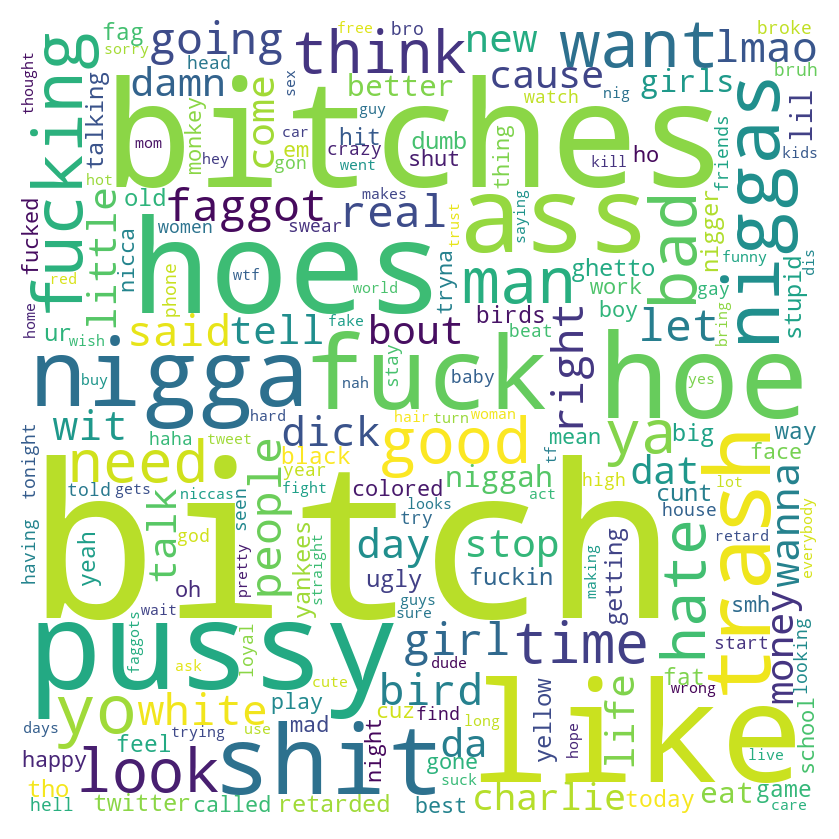

In [ ]:
# unigram
ngram_wordcloud(twitter_cleaned, 1)


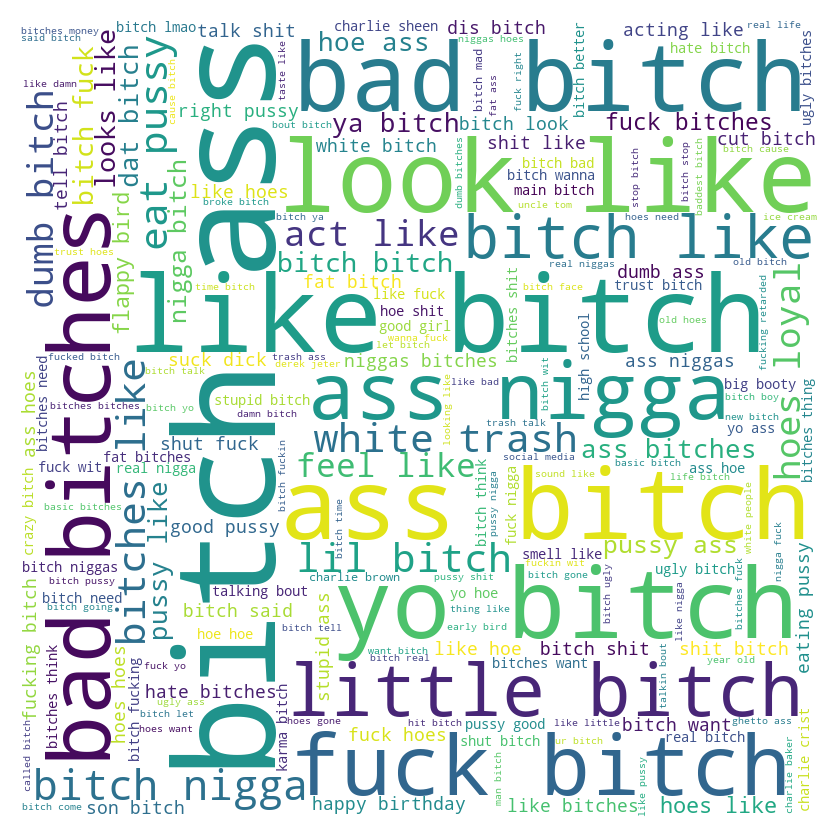

In [ ]:
# bigram
ngram_wordcloud(twitter_cleaned,2)

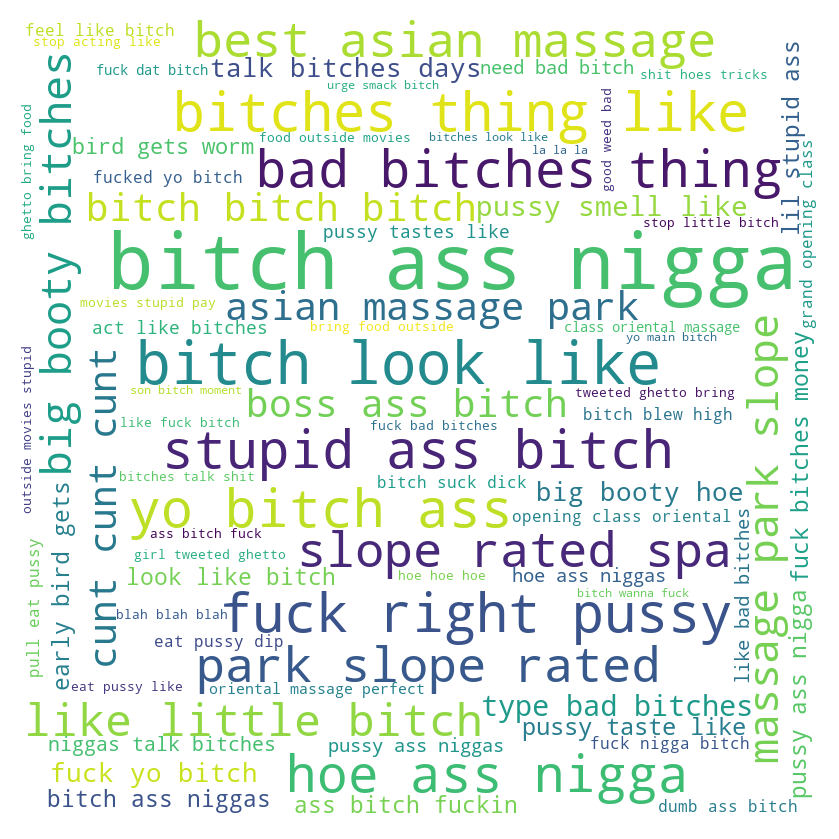

In [ ]:
# trigram
ngram_wordcloud(twitter_cleaned,3)

### Unsupervised Learning for Topic Modelling 

Using Topic Modelling to conduct a rough EDA on the frequent words under different topics

https://www.kaggle.com/code/thebrownviking20/topic-modelling-with-spacy-and-scikit-learn/notebook

In [ ]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True,\
                             token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}') # match such patterns at least two times
data_vectorized = vectorizer.fit_transform(twitter_cleaned.tweets_cleaned)
NUM_TOPICS = 6

In [ ]:
# Training Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

# Training Non-Negative Matrix Factorization Model
nmf = NMF(n_components=NUM_TOPICS)
data_nmf = nmf.fit_transform(data_vectorized) 

# Latent Semantic Indexing Model using Truncated SVD
lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [ ]:
# Function for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [ ]:
# Keywords for topics clustered by Latent Dirichlet Allocation
print("LDA Model Keywords ----------------------------------------")
selected_topics(lda, vectorizer)

# Keywords for topics clustered by Latent Semantic Indexing
print("NMF Model Keywords ----------------------------------------")
selected_topics(nmf, vectorizer)

# Keywords for topics clustered by Non-Negative Matrix Factorization
print("LSI Model Keywords ----------------------------------------")
selected_topics(lsi, vectorizer)

LDA Model Keywords ----------------------------------------
Topic 0:
[('bitch', 2255.134746424287), ('hoe', 1622.9321214350396), ('like', 446.6222311043448), ('tell', 333.10445485706276), ('ass', 269.5464331574047), ('ghetto', 264.67044985316033), ('yellow', 259.6973886885618), ('nigger', 216.96051556104678), ('yeah', 209.50798313588905), ('best', 184.6598813550443)]
Topic 1:
[('bitch', 2340.505482290037), ('bitches', 1474.98575799245), ('fuck', 1393.4348438787065), ('trash', 1163.4281212824073), ('nigga', 884.023464809233), ('like', 781.1444107876778), ('shit', 658.2290654081927), ('niggas', 648.1928333717867), ('bad', 578.2334788642452), ('ass', 483.3097878136193)]
Topic 2:
[('bitches', 1784.8375533095848), ('bitch', 1332.6852133522732), ('like', 572.1432668438906), ('hate', 465.572209083197), ('people', 436.84760669606095), ('bird', 388.6861440145956), ('white', 372.53606950687293), ('wit', 365.0084922426271), ('stop', 332.8946352080528), ('life', 320.688893807448)]
Topic 3:
[('puss


-  Topics on the left while their respective keywords are on the right.
-  Larger topics are more frequent and closer the topics, mor the similarity
-  Selection of keywords is based on their frequency and discriminancy.

In [ ]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
dash

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
1       1.465019 -47.625065       1        1  21.351723
3      54.854797 -36.476795       2        1  18.580258
2      32.212929 -61.444572       3        1  16.697797
0       5.111096 -14.110332       4        1  15.542420
4      26.350170 -33.374702       5        1  14.148318
5      38.109818  -7.222781       6        1  13.679484, topic_info=         Term         Freq        Total Category  logprob  loglift
1560     hoes  2465.000000  2465.000000  Default  30.0000  30.0000
2618    pussy  2018.000000  2018.000000  Default  29.0000  29.0000
306   bitches  3092.000000  3092.000000  Default  28.0000  28.0000
1559      hoe  1890.000000  1890.000000  Default  27.0000  27.0000
1313     fuck  1300.000000  1300.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
270   believe    78.317542    79.123968   Topic6  -5.4027   1.9790
3617    wants    78.372524    79.180691   Topic6  -5.4020   1.9790
1024     dyke    77.753490    78.559369   Topic6  -5.4099   1.9790
2253     need   142.424751   442.695312   Topic6  -4.8047   0.8552
285    better    85.126927   268.670615   Topic6  -5.3193   0.8399

[267 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
14        1  0.994545      act
141       5  0.995733      ask
147       1  0.305372      ass
147       2  0.222766      ass
147       3  0.178077      ass
...     ...       ...      ...
3770      2  0.996172  yankees
3779      4  0.997106     yeah
3780      1  0.990430     year
3786      4  0.995371   yellow
3795      3  0.995819    young

[261 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1, 5, 6])

## 3. Splitting to test and train data, ensuring balance of classes

In [ ]:
for i,j in enumerate(twitter_cleaned['neutral'].value_counts().sort_index()):
    print(i,j,j/twitter_hate.shape[0]*100)

0 20620 83.20219505306056
1 4163 16.797804946939436


Here the class labels are as such and are imbalanced:

0 = Hate (83.20%)
<br/> 1 = Neutral (16.80%)<br>


In [ ]:
import numpy as np
def split_input_output(data):
    '''
    Function returns input and output variables as separate arrays
    '''
    
    class_labels = ["neutral","hate"]
    
    # separating input and output 
    x = list(data["tweets_cleaned"])
    
    
    y = np.array(data[class_labels])
    return x,y # X = tweet data | y = [class neutral, class hate]

### Selecting the tweet as the feature, and class array as target
X, y = split_input_output(data=twitter_cleaned)

In [ ]:
### To check in feature-target split
print(X[:5])
print(y[:5])

[' woman complain cleaning house man trash', ' boy dats cold  tyga dwn bad cuffin dat hoe st place', ' dawg  fuck bitch start cry confused shit', ' look like tranny', ' shit hear true faker bitch told ya ']
[[1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]


In [ ]:
### Selecting the tweet as the feature, and class as target
#X = twitter_cleaned.tweets_cleaned
#y = twitter_cleaned['class']

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train + validation set & test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.1, 
                                                            shuffle=True, stratify=y, random_state = 42)

print(len(X_train_val))
print(y_train_val.shape)
print(len(X_test))
print(y_test.shape)

22304
(22304, 2)
2479
(2479, 2)


In [ ]:
# Split into train & validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, 
                                                  shuffle = True, stratify = y_train_val, random_state = 42)

print(len(X_train))
print(y_train.shape)
print(len(X_val))
print(y_val.shape)

17843
(17843, 2)
4461
(4461, 2)


In [ ]:
# saving train, cv and test processed data and labels
fp = "/content/drive/My Drive/Project/processed_data.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(obj=(X_train,
                     y_train,
                     X_val,
                     y_val,
                     X_test),
                file=f)

## 4. Solution 1: Dynamic Tagging

Text Generation Using LSTM

https://www.kaggle.com/code/shivamb/beginners-guide-to-text-generation-using-lstms/notebook

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [ ]:
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
# import keras.utils as ku 

In [ ]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

In [ ]:
inp_sequences, total_words = get_sequence_of_tokens(twitter_cleaned.tweets_cleaned)
inp_sequences[:10]

[[202, 825],
 [202, 825, 2981],
 [202, 825, 2981, 141],
 [202, 825, 2981, 141, 18],
 [202, 825, 2981, 141, 18, 11],
 [95, 969],
 [95, 969, 366],
 [95, 969, 366, 1276],
 [95, 969, 366, 1276, 6327],
 [95, 969, 366, 1276, 6327, 17]]

In [ ]:
import numpy as np
# !pip install --upgrade tensorflow
import keras.utils.np_utils as ku
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

In [ ]:
predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [ ]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 27, 10)            202490    
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 20249)             2045149   
                                                                 
Total params: 2,292,039
Trainable params: 2,292,039
Non-trainable params: 0
_________________________________________________________________


Can try to test with larger variety of data? 

In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
model.fit(predictors, label, epochs=10, verbose=5)

Epoch 1/10


KeyboardInterrupt: ignored

In [ ]:
model.save("/content/drive/My Drive/Project/model_2")

In [ ]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted = np.argmax(predicted,axis=1)       

        # predict_x=model.predict(X_test) 
        # classes_x=np.argmax(predict_x,axis=1)

        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [ ]:
import tensorflow as tf
new_model = tf.keras.models.load_model('/content/drive/My Drive/Project/model_2')

In [ ]:
print(generate_text("Yo", 5, new_model, max_sequence_len))

In [ ]:
print(generate_text("You are", 5, new_model, max_sequence_len))

In [ ]:
print(generate_text("You are not", 5, new_model, max_sequence_len))

In [ ]:
print(generate_text("How are you so", 5, new_model, max_sequence_len))

In [ ]:
print(generate_text("You are so", 5, new_model, max_sequence_len))

In [ ]:
print(generate_text("I am not a", 5, new_model, max_sequence_len))

In [ ]:
print(generate_text("Hi how are you, why are you", 5, new_model, max_sequence_len))

In [ ]:
print(generate_text("what do you mean, I don't want", 5, new_model, max_sequence_len))

What Do You Mean, I Don'T Want Bitch Nigga Fuck Nigga Fuck


After user types in a message, model automatically detects the next defined (K = number of relevant continuous words). Based on TF-IDF , we can set a threshold limit using n-grams or word frequency.

For example, if the top 10 words for the classified hate speech appears in the predicted phrase based on the sentence that the user has generated so far, a warning message will appear to the user - " If you post this message, and the message is tagged as a hate speech, you will be severely penalized" 

## 5. Solution 2: Predicting

Prediction Models Used:
<br>5.1 Bert
<br>5.2 XGBoost
<br>5.3 Multinomial Naive Bayes
<br>5.4 Log Regression

### Data Representation

#### Count Vectorizer

In [ ]:
### Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

#### Tf-idf Vectorizer

In [ ]:
### Tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect_basic = TfidfVectorizer()
tfidf_vect_norm = TfidfVectorizer(norm=None)
tfidf_vect_norm_stopwords = TfidfVectorizer(norm=None,stop_words='english')
tfidf_vect_norm_stopwords_ngram = TfidfVectorizer(norm=None,stop_words='english',
                                                  ngram_range=(1, 2))
tfidf_vect_norm_stopwords_ngram_maxdf = TfidfVectorizer(norm=None,stop_words='english',
                                                  ngram_range=(1, 2), max_df= 0.7)

#### Tokenizer

In [ ]:
### Tokenizer
# initially we will tokenize the corpus without passing any parameter for num_words 
from tensorflow.keras.preprocessing.text import Tokenizer
word_tokenizer = Tokenizer(num_words=None,
                           lower=True,
                           split=" ",
                           char_level=False) 

word_tokenizer.fit_on_texts(X_train)
total_words = len(word_tokenizer.word_index)
print(f'Number of unique words in vocabulary: {total_words}')

Number of unique words in vocabulary: 16846


In [ ]:
# finding the number of words which occur only once
num_words = 0
for word,count in word_tokenizer.word_counts.items():
    if count < 2:
        num_words += 1

print(f'Number of words in our vocabulary which occur only once: {num_words}')

# finding max number of words we need to consider
max_words = total_words - num_words
print(f'Number of words which occur at least two times: {max_words}')

Number of words in our vocabulary which occur only once: 9373
Number of words which occur at least two times: 7473


In [ ]:
# storing all document lengths in a list
import numpy as np
document_lengths = []

for doc in X_train:
    length = len(doc.split())
    document_lengths.append(length)

# finding the percentile values from 0 to 100 incrementing by 10 each iteration
for i in range(0,110,10):
    per_val = np.percentile(document_lengths,i)
    print(f'{i} percentile value is {per_val}')

0 percentile value is 0.0
10 percentile value is 2.0
20 percentile value is 3.0
30 percentile value is 4.0
40 percentile value is 5.0
50 percentile value is 6.0
60 percentile value is 7.0
70 percentile value is 8.0
80 percentile value is 9.0
90 percentile value is 11.0
100 percentile value is 27.0


In [ ]:
# finding the percentile values between 90 and 100 incrementing by 1 each iteration
for i in range(90,101):
    per_val = np.percentile(document_lengths,i)
    print(f'{i} percentile value is {per_val}')

90 percentile value is 11.0
91 percentile value is 11.0
92 percentile value is 12.0
93 percentile value is 12.0
94 percentile value is 12.0
95 percentile value is 13.0
96 percentile value is 13.0
97 percentile value is 13.0
98 percentile value is 14.0
99 percentile value is 15.0
100 percentile value is 27.0


In [ ]:
word_tokenizer = Tokenizer(num_words=max_words+1,
                           lower=True,
                           split=" ",
                           char_level=False) 

word_tokenizer.fit_on_texts(X_train)

# converting train,val and test into integere sequences
X_train = word_tokenizer.texts_to_sequences(X_train)
X_val = word_tokenizer.texts_to_sequences(X_val)
X_test = word_tokenizer.texts_to_sequences(X_test)

### Word-Embedding

In [ ]:
### WORD EMBEDDING ###

### GloVe Tf-idf



### Fast text (CRU, LSTM, CNN)

# loading pre-defined word embeddings and storing them as a dict
word_embeddings = dict()
with open("/content/drive/My Drive/Project/wiki-news-300d-1M.vec",encoding='utf-8') as f:
    for line in f:
        # extracting the token and corresponsing embedding
        tokens = line.rstrip().split(" ")  
        vector = np.asarray(tokens[1:], dtype='float32')
        word_embeddings[tokens[0]] = vector
        
print(f'Loaded 300d vector representations corresponding to {len(word_embeddings)} words') 

# creating a weight matrix for words in our training vocab
vocab_size = max_words + 1
embedding_matrix = np.zeros((vocab_size,300))

for word,index in word_tokenizer.word_index.items():
    # only considering max words
    if index < vocab_size:
        fasttext_vector = word_embeddings.get(word)
        # updating our weight matrix if fasttext vector corresponding to word exists
        if fasttext_vector is not None:
            embedding_matrix[index] = fasttext_vector
            
print(f'Shape of Embedding Matrix {embedding_matrix.shape}') 

# saving our fasttext embedding matrix on disk
fp = "/content/drive/My Drive/Project/fasttext_embedding_matrix.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(obj=embedding_matrix,
                file=f)

FileNotFoundError: ignored

### 5.1 BERT (done)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bert = TFAutoModel.from_pretrained("bert-base-cased")

In [ ]:
# define function to handle tokenization as BERT requires special embeddings
def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

# create tensor datasets for input ids, attention masks & labels
def create_tensorDataset(X, y, SEQ_LEN):
  X_ids = np.zeros((len(X), SEQ_LEN))
  X_mask = np.zeros((len(X), SEQ_LEN))

  # loop through data and tokenize everything
  for id, sentence in enumerate(X):
      X_ids[id, :], X_mask[id, :] = tokenize(sentence)

  # create tensor slices
  dataset = tf.data.Dataset.from_tensor_slices((X_ids, X_mask, y))

  # apply the mapping function to the dataset
  dataset = dataset.map(map_func)

  # batch the dataset(16 or 32 is ideal for BERT)
  dataset = dataset.batch(32)

  # iterate through dataset obj and fill up the tensor arrays
  # we've already split the dataset into train, val & test, so here we will take all rows of the X passed in
  dataset = dataset.take(X_ids.shape[0]) 
  
  return dataset

# map ids, masks & labels 
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [ ]:
# Set max sequence length for a sentence
SEQ_LEN = 50 # to try: 15

# Output tensor datasets for train, val & test set
train = create_tensorDataset(X_train, y_train, SEQ_LEN)
val = create_tensorDataset(X_val, y_val, SEQ_LEN)
test = create_tensorDataset(X_test, y_test, SEQ_LEN)

In [ ]:
# build the model
input_ids = tf.keras.layers.Input(shape=(50,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(50,), name='attention_mask', dtype='int32')

embeddings = bert(input_ids, attention_mask=mask)[0]  # we only keep tensor 0 (last_hidden_state)

X = tf.keras.layers.GlobalMaxPool1D()(embeddings)  # reduce tensor dimensionality
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation='relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
y = tf.keras.layers.Dense(2, activation='sigmoid', name='outputs')(X)  # adjust based on number of sentiment classes

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze the BERT layer
model.layers[2].trainable = False

model.summary()

In [ ]:
# defining callbacks

# filepath to save model
filepath = "bert.hdf5"

custom_metric = CustomMetrics(train_data=train,
                              train_labels=y_train,
                              val_data=val,
                              val_labels=y_val)
early_stop = EarlyStopping(monitor="val_loss",
                           patience=3,
                           verbose=1)
save_model = SaveModel(file_path=filepath)

# adding callbacks to single list
callbacks = [custom_metric,early_stop,save_model]

In [ ]:
# compile the model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy')

# and train it
model.fit(train, validation_data=val, epochs=10, callbacks=callbacks)

In [ ]:
bert_auc = roc_auc_score(y_true=y_test,
                                  y_score=model.predict(test),
                                  average="macro")
print(bert_auc)

### 5.2 XGBoost

In [ ]:
import xgboost as xg
#import BayesianOptimization as bay
from xgboost import XGBClassifier, plot_tree
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, mean_squared_error
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#!pip install transformers
from sklearn.pipeline import Pipeline

In [ ]:
def tokenize_test_xgb(vect, X_train, y_train, X_test, y_test):
    
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_val_dtm = vect.transform(X_val)

    print(X_train_dtm.shape)
    
    # print the number of features that were generated
    print('Features: ', X_train_dtm.shape[1])
    
    # use XGBClassifier
    #colsample_bytree = 1
    xgb = xg.sklearn.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
                                    gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=12,
                                    min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
                                    objective='binary:logistic', reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=42, silent=True, subsample=1)
    
    eval_s = [(X_train_dtm, y_train), (X_val_dtm, y_val)]
    model = xgb.fit(X_train_dtm, y_train, eval_metric="error", eval_set=eval_s, verbose=False)
    y_pred_class = xgb.predict(X_val_dtm)
    y_pred_proba = xgb.predict_proba(X_val_dtm)
    
    #classification report
    #print(classification_report(y_val,y_pred_class))
    
    # print accuracy.precision of its predictions
    print('Accuracy: ', metrics.accuracy_score(y_val, y_pred_class))
    print('Precision: ', metrics.precision_score(y_val, y_pred_class))
    print('ROC AUC: ', metrics.roc_auc_score(y_val,y_pred_proba[:,1]))
    print('Confusion Matrix: ', confusion_matrix(y_val, y_pred_class))

    # retrieve performance metrics 

    results = model.evals_result()
    #print(results)
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)

    #plot classification error
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend()
    plt.ylabel('Classification Error')
    plt.title('XGBoost Classification Error')
    plt.show()

    #Tree diagram
    plot_tree(model)
    plt.show()

In [ ]:
#CountVec
vect = CountVectorizer()
tokenize_test_xgb(vect, X_train, y_train, X_val, y_val)

#TFID 0.957
vect = TfidfVectorizer()
tokenize_test_xgb(vect, X_train, y_train, X_val, y_val)

vect = TfidfVectorizer(norm=None)
tokenize_test_xgb(vect, X_train, y_train, X_val, y_val)

vect = TfidfVectorizer(norm=None,stop_words='english')
tokenize_test_xgb(vect, X_train, y_train, X_val, y_val)

vect = TfidfVectorizer(norm=None,stop_words='english',ngram_range=(1, 2))
tokenize_test_xgb(vect, X_train, y_train, X_val, y_val)

#  max_features= 50000, max_df = 0.7
vect = TfidfVectorizer(norm=None,stop_words='english',ngram_range=(1, 2), max_df= 0.7)
tokenize_test_xgb(vect, X_train, y_train, X_val, y_val)

### 5.3 Multinomial NB (done)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Extracting data suitable for NB
X_train_nb = X_train
y_train_nb = y_train[:,1] # 0 = neutral, 1 = hate
X_val_nb = X_val
y_val_nb = y_val[:,1]
X_test_nb = X_test
y_test_nb = y_test[:,1]

# define a NB function that accepts a vectorizer and calculates the accuracy
def tokenize_test_nb(vect, X_train, y_train, X_val, y_val):
    
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_val_dtm = vect.transform(X_val)
    
    # print the number of features that were generated
    print('Features: ', X_train_dtm.shape[1])
    
    # use Multinomial Naive Bayes to predict the class labels of tweets
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_val_dtm)
    nb_pred_class = nb.predict(X_val_dtm) # gives specific class: 0/1
    nb_pred_proba = nb.predict_proba(X_val_dtm) # gives a list for each point [P(0), P(1)]

    
    # ACCURACY
    print('Accuracy----')
    print('Validation Accuracy: ', metrics.accuracy_score(y_val, nb_pred_class))
    
    # PRECISION
    print("Precision----")
    print('Test Precision: ', metrics.precision_score(y_val, nb_pred_class))
        
    # RECALL 
    print("Recall----")
    print('Test Recall: ', metrics.recall_score(y_val, nb_pred_class))
        
    # ROC_AUC
    print('ROC AUC----')
    print('Test roc_auc: ', metrics.roc_auc_score(y_val, nb_pred_proba[:,1]))

    #Confusion Matrix
    print('----')
    print('Test confusion_matrix: ', metrics.confusion_matrix(y_val, nb_pred_class))


In [ ]:
# Testing different Representations
print("> Count Vectorizer: ")
tokenize_test_nb(count_vect, X_train_nb, y_train_nb, X_val_nb, y_val_nb)

print("> Tf-idf Vectorizer [no hyperparameter tuning]: ")
tokenize_test_nb(tfidf_vect_basic, X_train_nb, y_train_nb, X_val_nb, y_val_nb)

print("> Tf-idf Vectorizer [norm = None]: ")
tokenize_test_nb(tfidf_vect_norm, X_train_nb, y_train_nb, X_val_nb, y_val_nb)

print("> Tf-idf Vectorizer [norm = None, stopword = english]: ")
tokenize_test_nb(tfidf_vect_norm_stopwords, X_train_nb, y_train_nb, X_val_nb, y_val_nb)

print("> Tf-idf Vectorizer [norm = None, stopword = english, ngram = (1,2)]: ")
tokenize_test_nb(tfidf_vect_norm_stopwords_ngram, X_train_nb, y_train_nb, X_val_nb, y_val_nb)

print("> Tf-idf Vectorizer [norm = None, stopword = english, ngram = (1,2), max_df = 0.7]: ")
tokenize_test_nb(tfidf_vect_norm_stopwords_ngram_maxdf, X_train_nb, y_train_nb, X_val_nb, y_val_nb)

> Count Vectorizer: 
Features:  16825
Accuracy----
Validation Accuracy:  0.9237839049540462
Precision----
Test Precision:  0.9279187817258884
Recall----
Test Recall:  0.9849137931034483
ROC AUC----
Test roc_auc:  0.9738485725219834
----
Test confusion_matrix:  [[ 465  284]
 [  56 3656]]
> Tf-idf Vectorizer [no hyperparameter tuning]: 
Features:  16825
Accuracy----
Validation Accuracy:  0.860345214077561
Precision----
Test Precision:  0.8572750404811473
Recall----
Test Recall:  0.9983836206896551
ROC AUC----
Test roc_auc:  0.9572312292827219
----
Test confusion_matrix:  [[ 132  617]
 [   6 3706]]
> Tf-idf Vectorizer [norm = None]: 
Features:  16825
Accuracy----
Validation Accuracy:  0.9036090562654113
Precision----
Test Precision:  0.9413663259817105
Recall----
Test Recall:  0.9428879310344828
ROC AUC----
Test roc_auc:  0.9076744927144238
----
Test confusion_matrix:  [[ 531  218]
 [ 212 3500]]
> Tf-idf Vectorizer [norm = None, stopword = english]: 
Features:  16806
Accuracy----
Validati

Highest accuracy on validation set: Tf-idf Vectorizer [norm = None, stopword = english, ngram = (1,2)]

In [ ]:
### Apply on Test Set
tokenize_test_nb(tfidf_vect_norm_stopwords_ngram, X_train_nb, y_train_nb, X_test_nb, y_test_nb)

Features:  90461
Accuracy----
Validation Accuracy:  0.9100443727309399
Precision----
Test Precision:  0.9435872709739633
Recall----
Test Recall:  0.9486185167232186
ROC AUC----
Test roc_auc:  0.9198335368581976
----
Test confusion_matrix:  [[ 299  117]
 [ 106 1957]]


### 5.4 Logistic Regression (done)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Extracting data suitable for LR
X_train_lr = X_train
y_train_lr = y_train[:,1] # 0 = neutral, 1 = hate
X_val_lr = X_val
y_val_lr = y_val[:,1]
X_test_lr = X_test
y_test_lr = y_test[:,1]

# define a NB function that accepts a vectorizer and calculates the accuracy
def tokenize_test_lr(vect, X_train, y_train, X_val, y_val):
    
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_val_dtm = vect.transform(X_val)
    
    # print the number of features that were generated
    print('Features: ', X_train_dtm.shape[1])
    
    # use Logistic Regression to predict the class labels of tweets
    # Regularization at 0.01, solver stochastic gradient , iterate for 500 epochs
    lr = LogisticRegression(C=100,solver='sag',max_iter=500)
    lr.fit(X_train_dtm, y_train)
    y_pred_class = lr.predict(X_val_dtm)
    lr_pred_class = lr.predict(X_val_dtm) # gives specific class: 0/1
    lr_pred_proba = lr.predict_proba(X_val_dtm) # gives a list for each point [P(0), P(1)]

    
    # ACCURACY
    print('Accuracy----')
    print('Validation Accuracy: ', metrics.accuracy_score(y_val, lr_pred_class))
    
    # PRECISION
    print("Precision----")
    print('Test Precision: ', metrics.precision_score(y_val, lr_pred_class))
        
    # RECALL 
    print("Recall----")
    print('Test Recall: ', metrics.recall_score(y_val, lr_pred_class))
        
    # ROC_AUC
    print('ROC AUC----')
    print('Test roc_auc: ', metrics.roc_auc_score(y_val, lr_pred_proba[:,1]))

    #Confusion Matrix
    print('----')
    print('Test confusion_matrix: ', metrics.confusion_matrix(y_val, lr_pred_class))

In [ ]:
# Testing different Representations
print("> Count Vectorizer: ")
tokenize_test_nb(count_vect, X_train_lr, y_train_lr, X_val_lr, y_val_lr)

print("> Tf-idf Vectorizer [no hyperparameter tuning]: ")
tokenize_test_nb(tfidf_vect_basic, X_train_lr, y_train_lr, X_val_lr, y_val_lr)

print("> Tf-idf Vectorizer [norm = None]: ")
tokenize_test_nb(tfidf_vect_norm, X_train_lr, y_train_lr, X_val_lr, y_val_lr)

print("> Tf-idf Vectorizer [norm = None, stopword = english]: ")
tokenize_test_nb(tfidf_vect_norm_stopwords, X_train_lr, y_train_lr, X_val_lr, y_val_lr)

print("> Tf-idf Vectorizer [norm = None, stopword = english, ngram = (1,2)]: ")
tokenize_test_nb(tfidf_vect_norm_stopwords_ngram, X_train_lr, y_train_lr, X_val_lr, y_val_lr)
print("> Tf-idf Vectorizer [norm = None, stopword = english, ngram = (1,2), max_df = 0.7]: ")
tokenize_test_nb(tfidf_vect_norm_stopwords_ngram_maxdf, X_train_lr, y_train_lr, X_val_lr, y_val_lr)


> Count Vectorizer: 
Features:  16825
Accuracy----
Validation Accuracy:  0.9237839049540462
Precision----
Test Precision:  0.9279187817258884
Recall----
Test Recall:  0.9849137931034483
ROC AUC----
Test roc_auc:  0.9738485725219834
----
Test confusion_matrix:  [[ 465  284]
 [  56 3656]]
> Tf-idf Vectorizer [no hyperparameter tuning]: 
Features:  16825
Accuracy----
Validation Accuracy:  0.860345214077561
Precision----
Test Precision:  0.8572750404811473
Recall----
Test Recall:  0.9983836206896551
ROC AUC----
Test roc_auc:  0.9572312292827219
----
Test confusion_matrix:  [[ 132  617]
 [   6 3706]]
> Tf-idf Vectorizer [norm = None]: 
Features:  16825
Accuracy----
Validation Accuracy:  0.9036090562654113
Precision----
Test Precision:  0.9413663259817105
Recall----
Test Recall:  0.9428879310344828
ROC AUC----
Test roc_auc:  0.9076744927144238
----
Test confusion_matrix:  [[ 531  218]
 [ 212 3500]]
> Tf-idf Vectorizer [norm = None, stopword = english]: 
Features:  16806
Accuracy----
Validati

Highest accuracy on validation set: Count Vectorizer

In [ ]:
### Apply on Test Set
tokenize_test_nb(count_vect, X_train_lr, y_train_lr, X_test_lr, y_test_lr)

Features:  16825
Accuracy----
Validation Accuracy:  0.9221460266236385
Precision----
Test Precision:  0.9265510948905109
Recall----
Test Recall:  0.9844886088221038
ROC AUC----
Test roc_auc:  0.9715966292553786
----
Test confusion_matrix:  [[ 255  161]
 [  32 2031]]
